In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
from importlib import reload
from dateutil.parser import parse
import scipy.linalg
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
import util.plot

In [4]:
reload(util.plot)

<module 'util.plot' from '/Users/mark/stack/doc/school/Data Mining Techniques/lab/util/plot.py'>

Generate a clean db with
```
python3 clean_odi.py
```

In [5]:
# %ls

In [6]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [7]:
data.describe()

,Unnamed: 0,Stress level,Day,Month,Year,Neighbours,Money
count,276.000000,276.000000,262.000000,262.000000,201.000000,276.000000,276.000000
mean,137.500000,38.500000,13.778626,6.419847,1993.985075,10.047101,35.241884
std,79.818544,33.933571,8.917493,3.411619,3.464791,23.019548,40.238578
min,0.000000,0.000000,0.000000,0.000000,1969.000000,0.000000,0.000000
25%,68.750000,10.000000,5.000000,4.000000,1993.000000,2.000000,1.000000
50%,137.500000,30.000000,13.000000,6.000000,1995.000000,3.000000,10.000000
75%,206.250000,65.000000,21.000000,9.000000,1996.000000,6.000000,80.000000
max,275.000000,100.000000,31.000000,12.000000,2001.000000,100.000000,100.000000


In [8]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand up,Rand,Good day (1),Good day (2),Stress level,Programme,Day,Month,Year,Neighbours,Money,Bedtime
0,0,3/27/2019 10:16:11,Yes,Yes,Yes,Yes,unknown,Slim,no,6,sun,lecture,30.0,AI,NaN,NaN,NaN,3.0,100.0,23:00:00
1,1,4/1/2019 15:58:21,No,No,Yes,Yes,male,Fat,no,7,DM,AI,1.0,AI,9.0,7.0,1992.0,1.0,0.0,03:00:00
2,2,4/1/2019 15:59:07,Yes,Yes,Unknown,Yes,male,Neither,unknown,0,0,0,100.0,CS,4.0,8.0,1995.0,0.0,0.0,00:00:00
3,3,4/1/2019 15:59:30,Yes,Yes,Yes,Yes,male,Fat,no,"1,645",Winning,Food,0.0,ECONOMETRICS,29.0,9.0,1993.0,2.0,42.0,00:30:00
4,4,4/1/2019 15:59:58,No,Yes,Yes,Yes,male,Neither,no,66,kiss,love,100.0,CS,5.0,4.0,NaN,2.0,10.0,20:00:00


In [9]:
for x in data.Neighbours[15:]:
#     print(x)
    float(x)

In [10]:
stat_exp = (data['Stat']).str.upper()
# stat_exp
# pd.Series.str.find()
# stat_exp[~stat_exp.isin(['A'])]
# stat_exp[~stat_exp.isin(keys)] = keys[-1]

In [11]:
# {i:k for i,k in enumerate(data.keys())}

In [12]:
# keys = {'What programme are you in?': 'Program',
#         'Have you taken a course on machine learning?': 'ML',
#         'Have you taken a course on information retrieval?': 'IR',
#         'Have you taken a course on statistics?': 'Stat',
#         'Have you taken a course on databases?': 'DB'}
# data.rename(index=str, columns=keys, inplace=True)
# # df.rename(index=str, columns={"A": "a", "B": "c"})
# data.keys()

In [13]:
# categorical = ['Program','ML','IR','DB','Stat']
numerical = ['Year', 'Money', 'Neighbours', 'Stress level']
categorical = list(data.keys())
for label in numerical:
    categorical.remove(label)
# irrelevant
categorical.remove('Timestamp')
categorical.remove('Unnamed: 0')
categorical.remove('Month')
categorical.remove('Day')
categorical.remove('Rand') # numerical & noisy
categorical.remove('Bedtime') # numerical & noisy
# too many categories
categorical.remove('Good day (1)')
categorical.remove('Good day (2)')
categorical.remove('Programme')
categorical

['ML', 'IR', 'Stat', 'DB', 'Gender', 'Chocolate', 'Stand up']

In [14]:
# def sum_dict(d):
#     return sum([sum([v for v in d[i].values()]) for i in d.keys()])

def summarize_categorical(data, k_x, k_y, conditional_x=False):
    # return the averages of each pair of categories
    # conditional_x means: P(Y|X=x) i.e. the distribution of Y given the value of X
    categories_x = data[k_x].unique()
    categories_y = data[k_y].unique()
    # init dict
    summary = collections.defaultdict(dict)
    # fill dict
    for c_x in categories_x:
        view = data.loc[data[k_x] == c_x, k_y]
        # TODO assert that labels are beautified
        summary[fix_label(c_x)] = view.value_counts(normalize=conditional_x) # average

    if not conditional_x:
        n = sum([a.sum() for a in summary.values()])
        for k_x in summary.keys():
            summary[k_x] /= n
    return summary

def fix_labels(labels):
    # update in-place
    for i, v in enumerate(labels.copy()):
        if v is None:
            labels[i] = 'None'
        else:
            labels[i] = fix_label(labels[i])

def fix_label(x):
    max_length = 12
    x = str.title(str(x))
    if x is None:
        assert False
        return 'None'
    translations = {'Ja': 'Yes', 'Nee': 'No', '1': 'Yes', '0':'No',
                   'I have no idea what you are talking about': 'Unknown'}
    if x in translations.keys():
        return translations[x]
    return x[:max_length]

# parse(data.Bedtime[0]).strftime('%M%m%d'), data.Bedtime[0]
# parse(data.Bedtime[0]).strftime(year_month_day + hour_min_sec), data.Bedtime[0]
# def format_data(data):
#     if ':' in data[0]:
#         return times_to_string(data)
#     return data
    
def times_to_string(times, *args, **kwargs):
    return [time_to_string(time, *args, **kwargs) for time in times]

def time_to_string(time, include_date=True):
    year_month_day = '%Y%m%d'
    hour_min_sec = '%H%M%S'
    if include_date:
        return parse(time).strftime(year_month_day + hour_min_sec)
    return parse(time).strftime(hour_min_sec)

def to_floats(X=[], default=0):
    try:
        return np.array(X).astype(float)
    except ValueError:
#         if ':' in X[0]:
            # assume dates
#             return times_to_string(X)
        for i,x in enumerate(X.copy()):
            try:
                if ':' in x:
                    x = x.replace(':','')
                if ',' in x:
                    # TODO and not '.' in x
                    x = x.replace(',','.')
                print(x)
                X[i] = float(x)
            except TypeError:
                X[i] = default
        return X

def plot_summary(ax, summary, show_grid=True):
    x_labels = list(summary.keys())
    y_labels = list(summary[x_labels[0]].keys())
    # TODO fix labels before plotting
    fix_labels(x_labels)
    fix_labels(y_labels)
    n_x = len(x_labels)
    n_y = len(y_labels)
    im = np.zeros((n_x, n_y))
    for i, k_x in enumerate(summary.keys()):
        for j, (k_y, v) in enumerate(summary[k_x].items()):
            im[i,j] = v
    # https://matplotlib.org/examples/color/colormaps_reference.html
    plt.imshow(im.T, origin='lower', vmin=0, vmax=1, cmap='terrain') # bone plasma rainbow pink cubehelix
    rotation = 0
    length = sum([len(label) for label in x_labels])
    if length > 10:
        rotation = 45
    else:
        rotation = 0        
#         plt.subplots_adjust(bottom=0.15)
    plt.xticks(np.arange(n_x), x_labels, rotation=rotation)
    rotation = 0
    length = sum([len(label) for label in y_labels])
    if length > 10:
        rotation = 45
    else:
        rotation = 0
    plt.yticks(np.arange(n_y), y_labels, rotation=rotation)
    plt.subplots_adjust(right=0.9)

    util.plot.show_grid(ax, im)
#     if show_grid:
#             # clear grid
#             ax.grid(False)        
#             # disable spines
#             for edge, spine in ax.spines.items():
#                     spine.set_visible(False)
#             # add custom grid
#             # add white grid to distinguish cells
#             lw = 3
#             ax.set_xticks(np.arange(im.shape[0]+1) - 0.5 + 0.005*lw, minor=True)
#             # ax.set_yticks(np.arange(im.shape[1]+1) - 0.5, minor=True)
#             ax.set_yticks(np.arange(im.shape[1]+1) - 0.5 + 0.01*lw, minor=True)            
#             ax.grid(which="minor", color='w', linestyle='-', linewidth=3)
#             ax.tick_params(which="minor", bottom=False, left=False)
    
    # TODO plot once
    return plt.colorbar

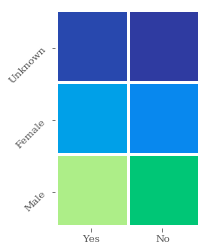

In [15]:
r = summarize_categorical(data, 'ML', 'Gender')
# r = {'A':{'e':0.9,'f':0.1, 'g':0.2}, 'B':{'e':0.1, 'f':0.1, 'g':0.3}, 'C':{'e':0.1, 'f':0.1, 'g':0.3}}
with plt.style.context(('ggplot')):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_summary(ax, r)
    
# TODO rm weird vertical line

In [16]:
def plot_correlations(data, keys, conditional_x=False):
    n_items = -1 # skip diagonal
    n_keys = len(keys) - 1
    rcParams['font.size'] = 14
    with plt.style.context(('ggplot')):
        fig = plt.figure(figsize=(18,12))
        # x
        for i_x, k_x in enumerate(keys):
            # y
            for i_y, k_y in enumerate(keys):
                if i_x < i_y:
                    # plt.subplot(n_keys, n_keys, i_x + i_y * n_keys + 1)
                    ax = fig.add_subplot(n_keys, n_keys, i_x + (i_y - 1) * n_keys + 1)
                    plot_correlation(ax, data, i_x, k_x, i_y, k_y, n_items, n_keys, conditional_x)

        plt.tight_layout()
        
def plot_correlation(ax, data, i_x, k_x, i_y, k_y, n_items, n_keys, conditional_x):
    if k_x in categorical:
        categories_x = data[k_x].unique()
        if k_y in categorical:
            categories_y = data[k_y].unique()
            # summarize
            summary = summarize_categorical(data, k_x, k_y, conditional_x)
            cb = plot_summary(ax, summary);
            # show colorbar
            #  cb()
        else:
            # summarize
            print('TODO \t', k_x, k_y)
            pass
    else:
        x = getattr(data, k_x)[:n_items]
        y = getattr(data, k_y)[:n_items]
        x = to_floats(x)
        y = to_floats(y)
        plt.scatter(x,y, s=9, alpha=0.8)
#         if k_x in ['Neighbours']:
#             plt.semilogx()
    
    if i_x == 0:
        plt.ylabel(k_y)
    if i_y == n_keys:
        plt.xlabel(k_x)    

In [27]:
data.Neighbours.max(), data.Neighbours.median()

(80.0, 3.0)

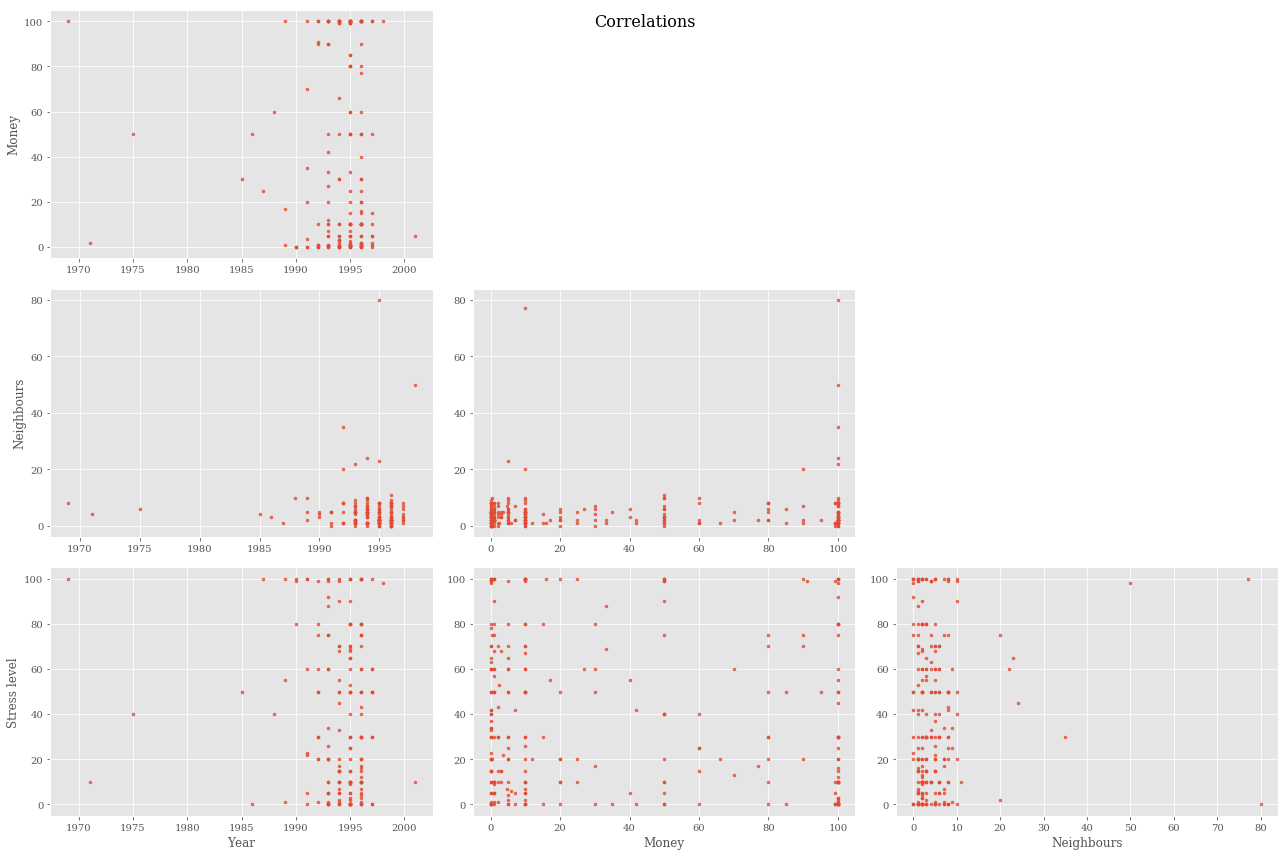

In [29]:
# data = pd.read_csv('ODI-2019-clean.csv', sep=';')
plot_correlations(data, numerical)
plt.suptitle('Correlations', fontsize=16)
util.plot.savefig('Correlations-grid')

In [24]:
data.Neighbours.max()

500.0

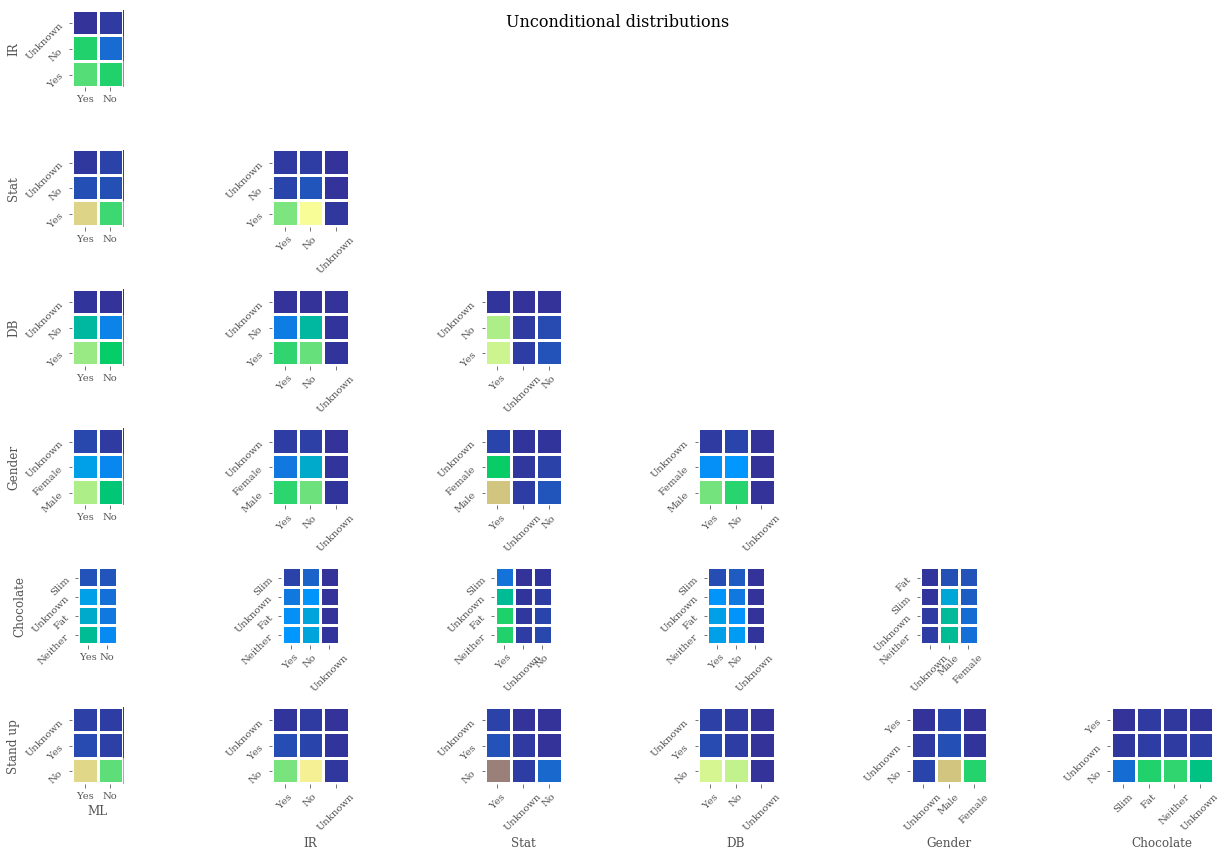

In [19]:
plot_correlations(data, categorical)
plt.suptitle('Unconditional distributions', fontsize=16)
util.plot.savefig('Unconditional-distributions-grid')

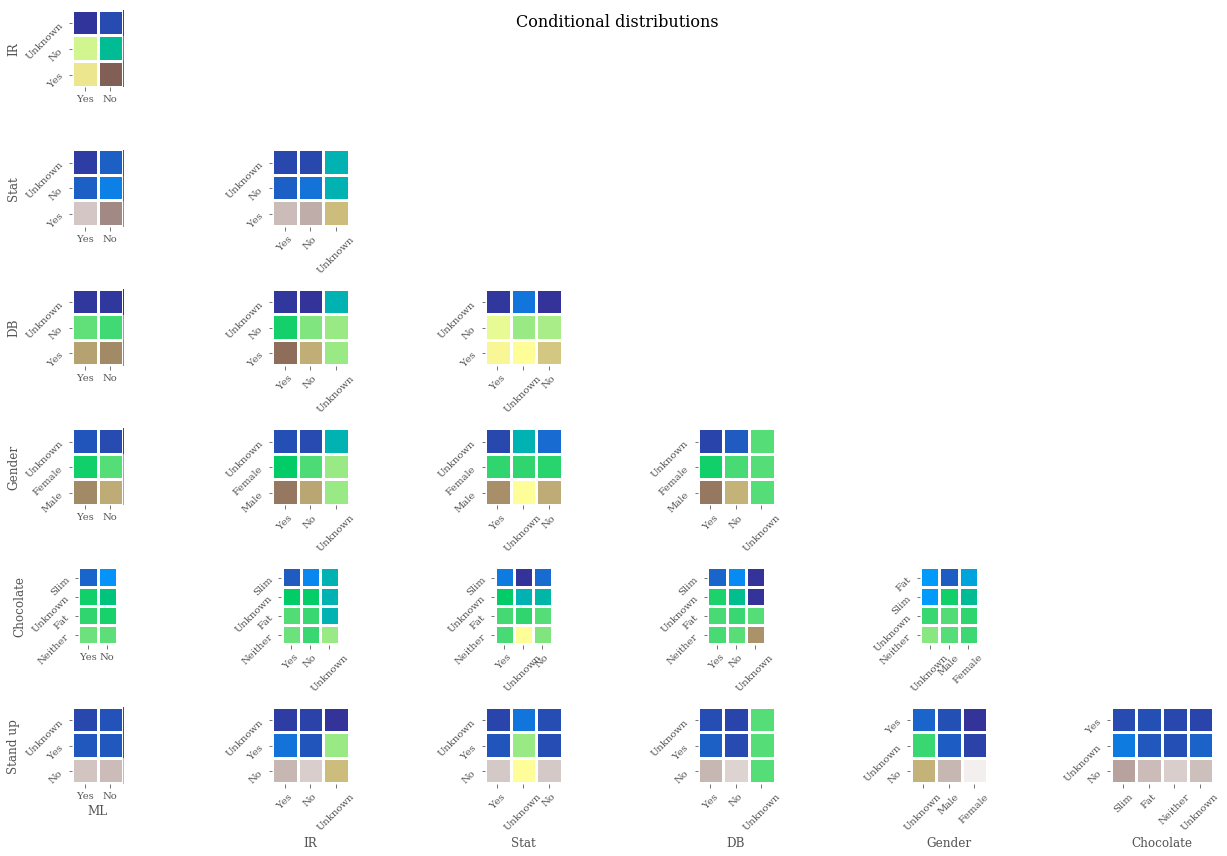

In [20]:
plot_correlations(data, categorical, conditional_x=True)
plt.suptitle('Conditional distributions', fontsize=16)
util.plot.savefig('Conditional-distributions-grid')